#DA 204o Data Science in Practice

Project: Online News Popularity

Authors: Rajat Chaudhary, Sonu Goyal, Srinivas Shavukapu Kattegummula, Yuvaraj G
email: rajatc@iisc.ac.in, sonugoyal@iisc.ac.in, srinivassk@iisc.ac.in, yuvarajgopi@iisc.ac.in

# 5-evaluation-and-analysis

### Feature Contribution

Extracting Built-in Importance...
Calculating Permutation Importance (Sampled)...
Processing Naive Bayes...


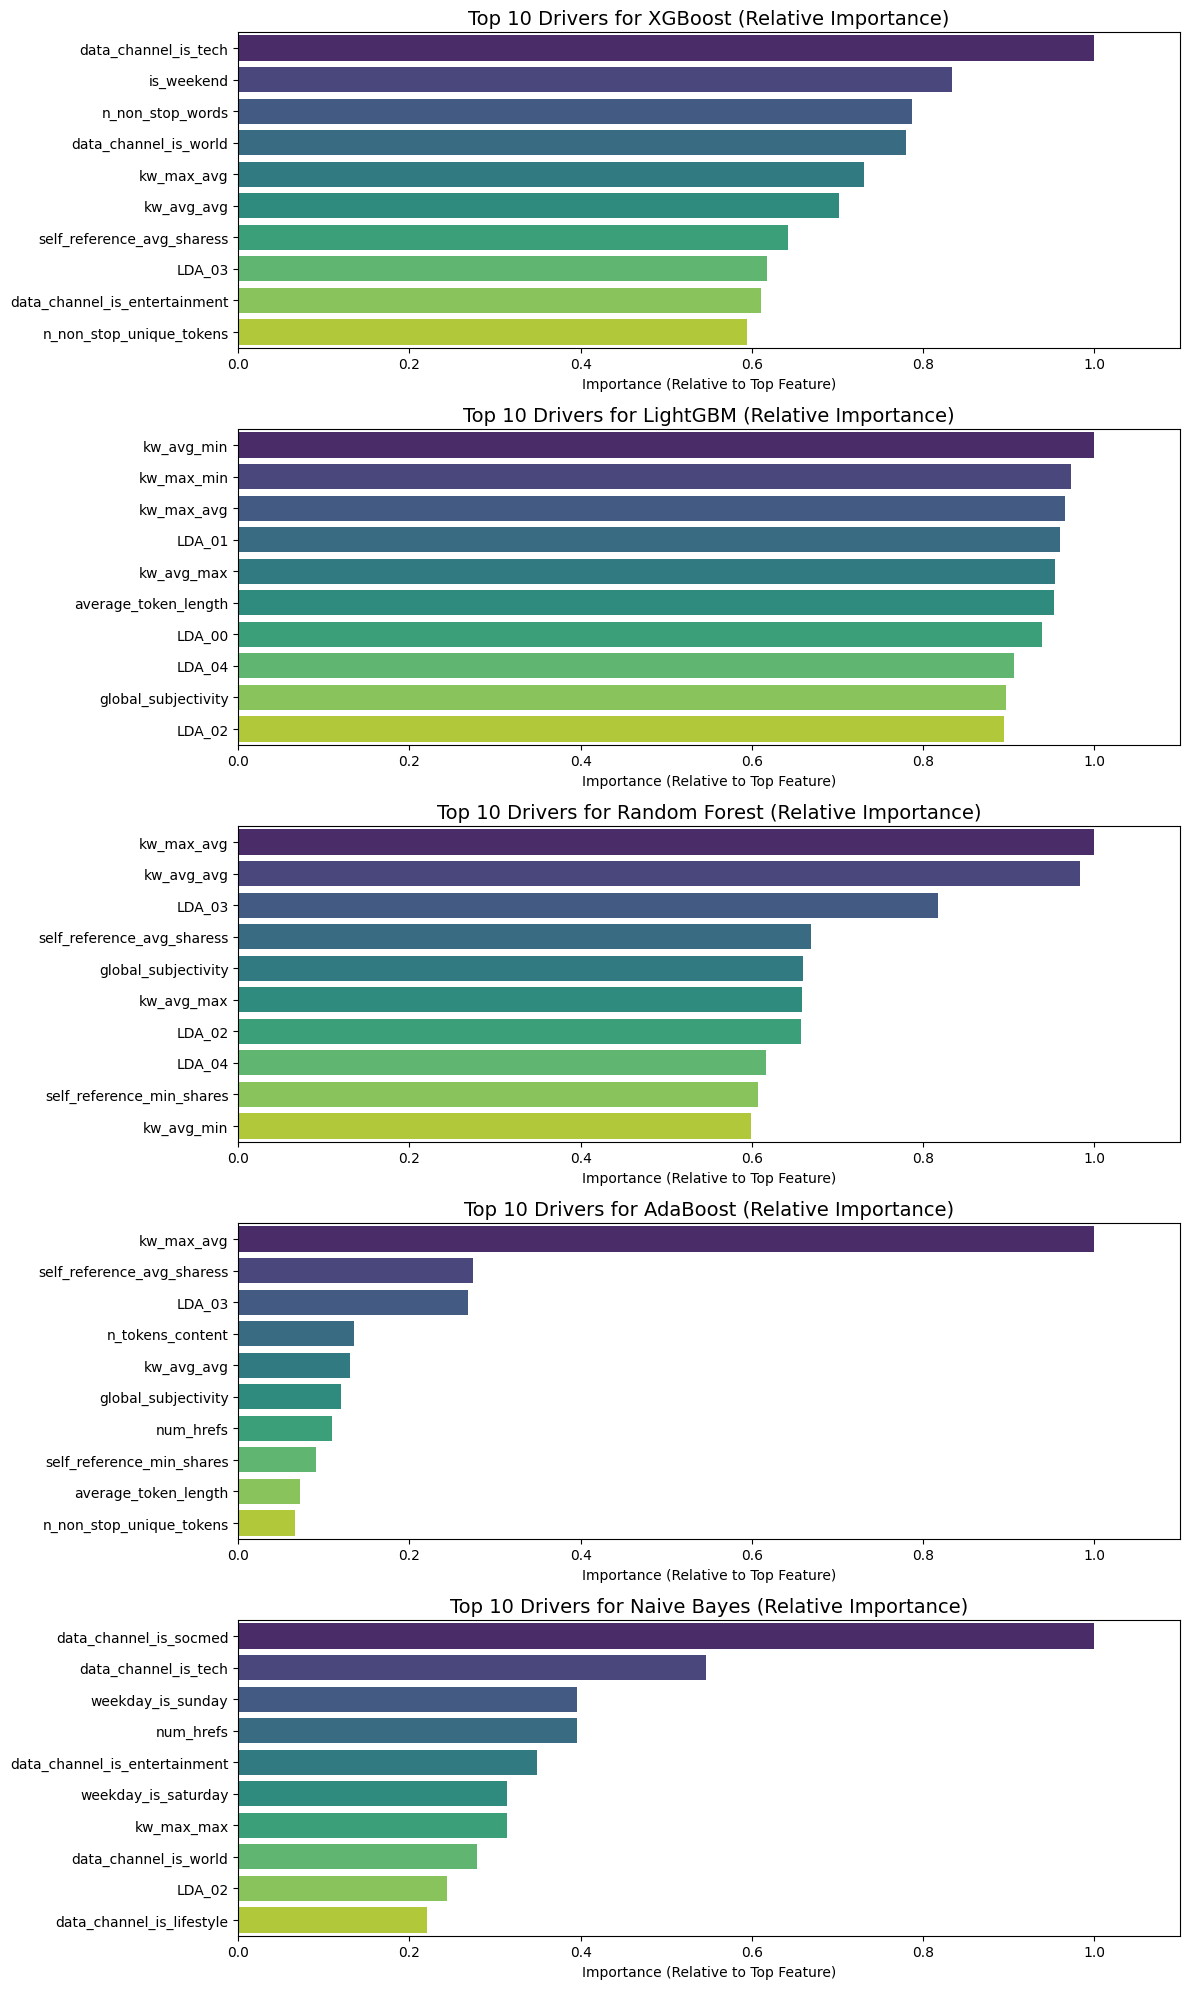

In [ ]:


# 1. ORGANIZE MODELS
tree_models = {
    "XGBoost": model_xgb,
    "LightGBM": model_lgbm,
    "Random Forest": model_rf,
    "AdaBoost": model_ada
}

other_models = {
    "Naive Bayes": nb_pipeline
}

all_importance = []

# --- PART A: FAST METHOD (Tree Built-in) ---
print("Extracting Built-in Importance...")

for name, model in tree_models.items():
    try:
        # Extract based on model type
        if hasattr(model, 'feature_importances_'):
            imps = model.feature_importances_
        elif hasattr(model, 'named_steps'): 
             # Handle pipelines (if any tree models are wrapped)
             clf = model.steps[-1][1]
             imps = clf.feature_importances_
        else:
            continue

        # NORMALIZE SCORES (Max value = 1.0)
        # This fixes the scale issue between different math formulas
        max_score = imps.max()
        if max_score > 0:
            imps = imps / max_score

        for i, feat_name in enumerate(X_test_model.columns):
            all_importance.append({
                'Model': name,
                'Feature': feat_name,
                'Importance': imps[i]
            })
    except Exception as e:
        print(f"Skipping {name}: {e}")

# --- PART B: PERMUTATION METHOD (Normalized) ---
print("Calculating Permutation Importance (Sampled)...")
X_sample = X_test_model.sample(1000, random_state=42)
y_sample = y_test_dynamic.loc[X_sample.index]

for name, model in other_models.items():
    print(f"Processing {name}...")
    result = permutation_importance(
        model, X_sample, y_sample, 
        n_repeats=5, 
        random_state=42, 
        n_jobs=-1
    )
    
    # NORMALIZE SCORES
    imps = result.importances_mean
    max_score = imps.max()
    if max_score > 0:
        imps = imps / max_score
    
    for i, feat_name in enumerate(X_test_model.columns):
        all_importance.append({
            'Model': name,
            'Feature': feat_name,
            'Importance': imps[i]
        })

# --- PART C: VISUALIZE (Same Scale) ---
df_imp = pd.DataFrame(all_importance)
unique_models = df_imp['Model'].unique()

plt.figure(figsize=(12, 4 * len(unique_models)))

for i, model_name in enumerate(unique_models):
    plt.subplot(len(unique_models), 1, i + 1)
    
    # Get Top 10
    data_subset = df_imp[df_imp['Model'] == model_name].sort_values(by='Importance', ascending=False).head(10)
    
    sns.barplot(x='Importance', y='Feature', data=data_subset, palette='viridis')
    
    plt.title(f'Top 10 Drivers for {model_name} (Relative Importance)', fontsize=14)
    plt.xlabel('Importance (Relative to Top Feature)', fontsize=10)
    plt.ylabel('')
    
    # SET SAME SCALE FOR ALL CHARTS
    # Since we normalized everything, 0 to 1.1 covers everything perfectly
    plt.xlim(0, 1.1) 

plt.tight_layout()
plt.show()

# Additional code (only for reference)

## Tuning code

In [32]:
import optuna

In [33]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_sample_weight

# 1. CALCULATE WEIGHTS (Crucial context for the tuner)
weights = compute_sample_weight(class_weight='balanced', y=y_train_dynamic)

def objective(trial):
    # --- A. Define the Search Space ---
    params = {
        # Core Parameters
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        
        # Outlier Handling (Critical for Viral hits)
        # We allow smaller child weights to catch rare viral clusters
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 8),
        
        # Regularization (To prevent memorizing noise)
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
        
        # Fixed settings
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist',
        'objective': 'multi:softprob',
        'num_class': 4,
        'eval_metric': 'auc',
        'early_stopping_rounds': 50
    }
    
    # --- B. Train the Model ---
    model = XGBClassifier(**params)
    
    model.fit(
        X_train_model, 
        y_train_dynamic,
        sample_weight=weights,  # <--- CRITICAL: Tune using the weighted logic
        eval_set=[(X_test_model, y_test_dynamic)],
        verbose=0
    )
    
    # --- C. Custom Evaluation (Maximize Viral F1) ---
    preds = model.predict(X_test_model)
    
    # Calculate F1 score specifically for Class 3 (Viral)
    # average=None gives [F1_Class0, F1_Class1, F1_Class2, F1_Class3]
    f1_scores = f1_score(y_test_dynamic, preds, average=None, zero_division=0)
    viral_f1 = f1_scores[3] 
    
    # We can also optimize for (Viral F1 + Trending F1) / 2 if you want both
    # trending_f1 = f1_scores[2]
    # return (viral_f1 + trending_f1) / 2
    
    return viral_f1

# --- D. Run the Optimization ---
print("Starting Hyperparameter Tuning for VIRAL DETECTION...")
# We use direction='maximize' because we want Higher F1 Score
study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=30) # 30 Trials is a good balance of speed/results

print("\n" + "="*50)
print("BEST HYPERPARAMETERS FOUND:")
print("="*50)
print(study.best_params)
print(f"Best Viral F1 Score: {study.best_value:.4f}")

[I 2025-11-29 23:06:54,510] A new study created in memory with name: no-name-dfe67b54-b42d-4484-8222-9cf0e4ee5bcd


Starting Hyperparameter Tuning for VIRAL DETECTION...


[I 2025-11-29 23:07:01,005] Trial 0 finished with value: 0.03322259136212625 and parameters: {'learning_rate': 0.030400707202722095, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8140526173072848, 'colsample_bytree': 0.9569542346342468, 'reg_alpha': 4.049077958863487, 'reg_lambda': 0.1420806738043722}. Best is trial 0 with value: 0.03322259136212625.
[I 2025-11-29 23:07:04,238] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 0.19427625690977696, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.843036705714794, 'colsample_bytree': 0.9570800307686307, 'reg_alpha': 0.03655566762011286, 'reg_lambda': 0.0260832614866867}. Best is trial 0 with value: 0.03322259136212625.
[I 2025-11-29 23:07:09,370] Trial 2 finished with value: 0.0 and parameters: {'learning_rate': 0.08297290330981275, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.6879933106880286, 'colsample_bytree': 0.7231229817350083, 'reg_alpha': 0.2342754141157885, 'reg_lambda': 5.988995178258414}


BEST HYPERPARAMETERS FOUND:
{'learning_rate': 0.045306388158680516, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.7703082678213902, 'colsample_bytree': 0.8183496054843995, 'reg_alpha': 0.012003463442738416, 'reg_lambda': 0.025843019241612523}
Best Viral F1 Score: 0.0515


In [34]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.metrics import f1_score

def objective_lgbm(trial):
    # --- A. Search Space ---
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        
        # num_leaves: The complexity control. 
        # Higher = More Viral Hits, but more Overfitting.
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True),
        
        # Fixed
        'class_weight': 'balanced',
        'objective': 'multiclass',
        'num_class': 4,
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }
    
    model = LGBMClassifier(**params)
    
    # --- B. Train ---
    # We use a callback for early stopping
    model.fit(
        X_train_model, 
        y_train_dynamic,
        eval_set=[(X_test_model, y_test_dynamic)],
        eval_metric='auc_mu',
        callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    # --- C. Optimize for Viral F1 ---
    preds = model.predict(X_test_model)
    f1_scores = f1_score(y_test_dynamic, preds, average=None, zero_division=0)
    viral_f1 = f1_scores[3] 
    
    return viral_f1

print("Starting LightGBM Tuning...")
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=30)

print("\nBEST LIGHTGBM PARAMS:")
print(study_lgbm.best_params)

[I 2025-11-29 23:09:58,690] A new study created in memory with name: no-name-efc115a9-3dd7-431a-873c-092ff3c2bdf0


Starting LightGBM Tuning...


[I 2025-11-29 23:09:59,695] Trial 0 finished with value: 0.038461538461538464 and parameters: {'learning_rate': 0.24150665342152364, 'num_leaves': 26, 'min_child_samples': 32, 'subsample': 0.9851866713611297, 'colsample_bytree': 0.9847298562667572, 'reg_alpha': 0.012965623279870591, 'reg_lambda': 0.020044708333464643}. Best is trial 0 with value: 0.038461538461538464.
[I 2025-11-29 23:10:06,755] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 0.11500664926522508, 'num_leaves': 91, 'min_child_samples': 13, 'subsample': 0.7488408624516563, 'colsample_bytree': 0.974317740823113, 'reg_alpha': 0.2398693877885998, 'reg_lambda': 0.020319673733133994}. Best is trial 0 with value: 0.038461538461538464.
[I 2025-11-29 23:10:08,141] Trial 2 finished with value: 0.051351351351351354 and parameters: {'learning_rate': 0.0831439964596283, 'num_leaves': 26, 'min_child_samples': 39, 'subsample': 0.9313727573019516, 'colsample_bytree': 0.6397782350008651, 'reg_alpha': 9.956738787427893


BEST LIGHTGBM PARAMS:
{'learning_rate': 0.06955236764638185, 'num_leaves': 81, 'min_child_samples': 37, 'subsample': 0.6023496417255091, 'colsample_bytree': 0.870954159721603, 'reg_alpha': 3.0588002966298684, 'reg_lambda': 1.0217968173749326}


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

def objective_rf_viral(trial):
    # --- 1. Define Search Space ---
    params = {
        # n_estimators: More trees = Smoother predictions (but slower)
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        
        # max_depth: Limits how complex the trees can get
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        
        # min_samples_split: Minimum samples required to split an internal node
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        
        # min_samples_leaf: CRITICAL. 
        # Higher values (e.g., 5-10) smooth out noise and stop overfitting.
        # Lower values (e.g., 1) capture specific viral outliers.
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        
        # max_features: 'sqrt' is standard, 'log2' uses fewer features (more diversity)
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        
        # class_weight: 'balanced' or 'balanced_subsample'
        # 'balanced_subsample' calculates weights for every tree individually (More aggressive)
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),
        
        # Fixed
        'random_state': 42,
        'n_jobs': -1
    }
    
    # --- 2. Train ---
    model = RandomForestClassifier(**params)
    model.fit(X_train_model, y_train_dynamic)
    
    # --- 3. Evaluate (Maximize Viral F1) ---
    preds = model.predict(X_test_model)
    
    # Calculate F1 specifically for Class 3 (Viral)
    _, _, f1_scores, _ = precision_recall_fscore_support(y_test_dynamic, preds, average=None, zero_division=0)
    viral_f1 = f1_scores[3]
    
    return viral_f1

print("Starting Random Forest Viral Tuning...")
study_rf_viral = optuna.create_study(direction='maximize') 
study_rf_viral.optimize(objective_rf_viral, n_trials=30)

print("\nBEST RANDOM FOREST PARAMS:")
print(study_rf_viral.best_params)

[I 2025-11-29 23:11:31,961] A new study created in memory with name: no-name-28c0b015-3722-4395-9cfe-00819e24e2c2


Starting Random Forest Viral Tuning...


[I 2025-11-29 23:11:43,345] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 754, 'max_depth': 46, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.0.
[I 2025-11-29 23:11:50,700] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 419, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.0.
[I 2025-11-29 23:11:56,218] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 309, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.0.
[I 2025-11-29 23:12:00,661] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 242, 'max_depth': 48, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0


BEST RANDOM FOREST PARAMS:
{'n_estimators': 754, 'max_depth': 46, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}


In [36]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support

def objective_ada_viral(trial):
    # --- 1. Tune the Base Estimator (The Tree) ---
    # AdaBoost usually uses Depth=1 (Stumps), but for complex Viral rules, we try deeper.
    tree_depth = trial.suggest_int('tree_depth', 1, 8)
    
    # We tune min_samples_leaf to prevent the tree from memorizing noise
    leaf_size = trial.suggest_int('min_samples_leaf', 1, 20)
    
    base_tree = DecisionTreeClassifier(
        max_depth=tree_depth,
        min_samples_leaf=leaf_size,
        class_weight='balanced', # <--- CRITICAL: Force the tree to find Viral hits
        random_state=42
    )
    
    # --- 2. Tune the AdaBoost Wrapper ---
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
        'algorithm': 'SAMME', # Fixed for newer Scikit-Learn
        'random_state': 42
    }
    
    # --- 3. Train ---
    model = AdaBoostClassifier(estimator=base_tree, **params)
    model.fit(X_train_model, y_train_dynamic)
    
    # --- 4. Evaluate (Maximize Viral F1) ---
    preds = model.predict(X_test_model)
    
    # Calculate F1 specifically for Class 3 (Viral)
    _, _, f1_scores, _ = precision_recall_fscore_support(y_test_dynamic, preds, average=None, zero_division=0)
    viral_f1 = f1_scores[3]
    
    return viral_f1

print("Starting AdaBoost Viral Tuning...")
study_ada_viral = optuna.create_study(direction='maximize') # Higher F1 is better
study_ada_viral.optimize(objective_ada_viral, n_trials=30)

print("\nBEST ADABOOST PARAMS:")
print(study_ada_viral.best_params)

[I 2025-11-29 23:15:20,603] A new study created in memory with name: no-name-58e7ed1e-cafa-456d-917e-280ee5832c52


Starting AdaBoost Viral Tuning...


[I 2025-11-29 23:16:14,163] Trial 0 finished with value: 0.026107425636635994 and parameters: {'tree_depth': 1, 'min_samples_leaf': 3, 'n_estimators': 719, 'learning_rate': 0.08101215931077241}. Best is trial 0 with value: 0.026107425636635994.
[I 2025-11-29 23:18:12,768] Trial 1 finished with value: 0.02865329512893983 and parameters: {'tree_depth': 8, 'min_samples_leaf': 12, 'n_estimators': 953, 'learning_rate': 0.03634518925368457}. Best is trial 1 with value: 0.02865329512893983.
[I 2025-11-29 23:21:39,242] Trial 2 finished with value: 0.03164556962025317 and parameters: {'tree_depth': 8, 'min_samples_leaf': 3, 'n_estimators': 648, 'learning_rate': 0.02053801012439883}. Best is trial 2 with value: 0.03164556962025317.
[I 2025-11-29 23:21:44,385] Trial 3 finished with value: 0.04302567661346287 and parameters: {'tree_depth': 4, 'min_samples_leaf': 18, 'n_estimators': 637, 'learning_rate': 0.09949039931895795}. Best is trial 3 with value: 0.04302567661346287.
[I 2025-11-29 23:23:26,0


BEST ADABOOST PARAMS:
{'tree_depth': 5, 'min_samples_leaf': 12, 'n_estimators': 485, 'learning_rate': 0.013114266189401223}


In [37]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_fscore_support

def objective_nb_viral(trial):
    # --- 1. Define Search Space ---
    # var_smoothing: Added variance to calculation stability.
    # High value = Smoother curve (Less overfitting).
    # Low value = Exact curve (More aggressive).
    smoothing = trial.suggest_float('var_smoothing', 1e-10, 1.0, log=True)
    
    # --- 2. Build Pipeline ---
    model = make_pipeline(
        PowerTransformer(), # Always keep this for your data
        GaussianNB(var_smoothing=smoothing)
    )
    
    # --- 3. Train ---
    model.fit(X_train_model, y_train_dynamic)
    
    # --- 4. Evaluate (Maximize Viral F1) ---
    preds = model.predict(X_test_model)
    _, _, f1_scores, _ = precision_recall_fscore_support(y_test_dynamic, preds, average=None, zero_division=0)
    viral_f1 = f1_scores[3]
    
    return viral_f1

print("Starting Naive Bayes Viral Tuning...")
study_nb = optuna.create_study(direction='maximize')
study_nb.optimize(objective_nb_viral, n_trials=20) # Very fast to tune

print("\nBEST NB PARAMS:")
print(study_nb.best_params)

[I 2025-11-29 23:45:14,203] A new study created in memory with name: no-name-57a403ec-5010-465c-a515-17e9290235f0


Starting Naive Bayes Viral Tuning...


[I 2025-11-29 23:45:14,802] Trial 0 finished with value: 0.05194805194805195 and parameters: {'var_smoothing': 0.014396856084588754}. Best is trial 0 with value: 0.05194805194805195.
[I 2025-11-29 23:45:15,374] Trial 1 finished with value: 0.05091937765205092 and parameters: {'var_smoothing': 7.86194884641437e-07}. Best is trial 0 with value: 0.05194805194805195.
[I 2025-11-29 23:45:15,992] Trial 2 finished with value: 0.05091937765205092 and parameters: {'var_smoothing': 1.0772437525192276e-05}. Best is trial 0 with value: 0.05194805194805195.
[I 2025-11-29 23:45:16,574] Trial 3 finished with value: 0.05091937765205092 and parameters: {'var_smoothing': 4.4431563434632204e-05}. Best is trial 0 with value: 0.05194805194805195.
[I 2025-11-29 23:45:17,171] Trial 4 finished with value: 0.05091937765205092 and parameters: {'var_smoothing': 8.171102287857293e-05}. Best is trial 0 with value: 0.05194805194805195.
[I 2025-11-29 23:45:17,754] Trial 5 finished with value: 0.05091937765205092 and


BEST NB PARAMS:
{'var_smoothing': 0.34669708337580335}
